### Imports

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel
from peft import get_peft_model, LoraConfig, TaskType
from PIL import Image
import random
import pandas as pd
import os
import ast
import numpy as np

/Users/ujwalkarippalichandran/Ujwal /Masters/Sem2/NLP/Project/NLP-Project/nlp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
print(np.__version__)

1.26.4


In [3]:
from dotenv import load_dotenv
import os

load_dotenv()
api_key = os.getenv("OPENROUTER_API_KEY")

In [101]:
# from openai import OpenAI

# client = OpenAI(
#     base_url="https://openrouter.ai/api/v1",
#     api_key=api_key
# )

# def gloss_text(text):
#     try:
#         response = client.chat.completions.create(
#             model="deepseek/deepseek-r1-zero:free",
#             messages=[
#                 {"role": "system", "content": "You convert idiomatic or ambiguous English sentences into clear literal gloss sentences."},
#                 {"role": "user", "content": f"Gloss this sentence: {text}"}
#             ]
#         )
#         print(response)
#         return response.choices[0].message.content.strip()
#     except Exception as e:
#         print(response)
#         print(f"Glossing failed: {e}")
#         return text  # fallback to original

### API calls to DeepSeek

In [ ]:
import requests
import json
import time

def gloss_text(text, max_retries=3, retry_delay=2):
    url = "https://openrouter.ai/api/v1/chat/completions"
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json"
    }

    payload = {
        "model": "deepseek/deepseek-r1-zero:free",
        "messages": [
            {
                "role": "system",
                "content": (
                    "You are a language expert. Your task is to convert idiomatic or figurative language into literal explanations.\n"
                    "- If the sentence contains an idiom or figurative expression, rewrite it by replacing those parts with clear, literal meanings.\n"
                    "- If it doesn't, return the sentence unchanged.\n"
                    "DO NOT explain your reasoning or provide commentary. ONLY return the final rewritten sentence."
                )
            },
            {
                "role": "user",
                "content": text
            }
        ],
        "reasoning": {
            "effort": "low",
            "exclude": True 
        }
    }

    for attempt in range(1, max_retries + 1):
        try:
            response = requests.post(url, headers=headers, data=json.dumps(payload))
            result = response.json()
            content = result["choices"][0]["message"]["content"].strip()

            if content:
                return content
            else:
                print(f"Attempt {attempt}: Empty content received. Retrying...")
                time.sleep(retry_delay)

        except Exception as e:
            print(f"Attempt {attempt}: Glossing failed due to error: {e}")
            time.sleep(retry_delay)

    print("Max retries reached. Returning original text.")
    return text



### For glossing the sentences

In [52]:
import re

def preprocess_gloss(df):
    gloss_cache = {}
    for _, row in df.iterrows():
        if row["sentence"] not in gloss_cache:
            sentence = row["sentence"]
            #gloss = gloss_idiomatic_sentence(sentence)
            gloss = gloss_text(sentence)
            # Extract from \boxed{...}
            match = re.search(r"\\boxed\{(.+?)\}", gloss)
            extracted = match.group(1).strip() if match else gloss.strip()
            #print(extracted)
            gloss_cache[sentence] = extracted if extracted != "" else sentence
            print(f"\n Sentence: {sentence}\n Gloss: {gloss_cache[sentence]}\n")
    return gloss_cache

In [111]:
print(gloss_text("Its raining cats and dogs"))

new one
ChatCompletion(id='gen-1745806445-LfisyYGvUtLNSgajdaso', choices=[Choice(finish_reason='length', index=0, logprobs=None, message=ChatCompletionMessage(content='', refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=None, reasoning='To solve for whether the sentence contains an idiom or figurative expression, let us first identify any part of the sentence that might be an idiom or a figurative expression. \n\nThe sentence given is:\n"He moved from the 10 pm slot to his lower profile life as a DJ on Radio Norwich\'s graveyard shift."\n\nThe part of the sentence that seems like a potential idiom or figurative expression is "graveyard shift." \n\nThe term "graveyard shift" typically refers to a work shift that takes place during the late night to early morning hours, usually from midnight until 8 a.m. It is called a "graveyard shift" because it is a time when most people are asleep, which makes it a quiet and often less desirable shift to wo

### Load datasets

In [14]:
train_df = pd.read_csv("train/subtask_a_train.tsv", sep='\t')
dev_df = pd.read_csv("dev/subtask_a_dev.tsv", sep='\t')
test_df = pd.read_csv("test/subtask_a_test.tsv", sep='\t')

### The following code creates gloss sentences for train, dev, test using DeepSeek

In [394]:
# train_df_1 = train_df[0:30]
# train_df_2 = train_df[30:60]
# train_df_3 = train_df[60:]

# gloss_sentences_train_1 = preprocess_gloss(train_df_1)
# gloss_sentences_train_2 = preprocess_gloss(train_df_2)
# gloss_sentences_train_3 = preprocess_gloss(train_df_3)

# with open("gloss_sentences_train1.json", "w") as file:
#     json.dump(gloss_sentences_train_1, file, indent=4)

# with open("gloss_sentences_train2.json", "w") as file:
#     json.dump(gloss_sentences_train_2, file, indent=4)

# with open("gloss_sentences_train3.json", "w") as file:
#     json.dump(gloss_sentences_train_3, file, indent=4)

# with open('gloss_sentences_train1.json', 'r') as f:
#     data1 = json.load(f)

# with open('gloss_sentences_train2.json', 'r') as f:
#     data2 = json.load(f)

# with open('gloss_sentences_train3.json', 'r') as f:
#     data3 = json.load(f)

# train_data = {**data1, **data2, **data3}

# with open('gloss_sentences_train.json', 'w') as file:
#     json.dump(train_data, file, indent=4)

# gloss_sentences_dev = preprocess_gloss(dev_df)

# with open("gloss_sentences_dev.json", "w") as file:
#     json.dump(gloss_sentences_dev, file, indent=4)

# gloss_sentences_test = preprocess_gloss(test_df)

# with open("gloss_sentences_test.json", "w") as file:
#     json.dump(gloss_sentences_test, file, indent=4)

### Opening the files that have stored the gloss sentences

In [4]:
import json
with open("gloss_sentences_train.json", "r") as file:
    gloss_cache_train = json.load(file)

with open("gloss_sentences_dev.json", "r") as file:
    gloss_cache_dev = json.load(file)

with open("gloss_sentences_test.json", "r") as file:
    gloss_cache_test = json.load(file)

### Create Dataset

In [5]:
class TripletDataset(Dataset):
    def __init__(self, df, gloss_cache = None):
        self.anchor_positive_negative_triplets = []
        self.gloss_cache = gloss_cache

        for index, row in df.iterrows():
            expected_order = ast.literal_eval(row["expected_order"])
            for i in range(1, 5):
                if self.gloss_cache is not None:
                    sentence = gloss_cache[row["sentence"]]
                else:
                    sentence = row["sentence"]
                self.anchor_positive_negative_triplets.append((
                    sentence,
                    os.path.join("train", row["compound"].replace("'s", "_s"), expected_order[0]),
                    os.path.join("train", row["compound"].replace("'s", "_s"), expected_order[i])
                ))

    def __len__(self):
        return len(self.anchor_positive_negative_triplets)

    def __getitem__(self, idx):
        anchor_text, pos_img_path, neg_img_path = self.anchor_positive_negative_triplets[idx]
        pos_img = Image.open(pos_img_path).convert('RGB')
        neg_img = Image.open(neg_img_path).convert('RGB')
        return (anchor_text, pos_img, neg_img)

### Triplet Loss function using cosine similarity

In [6]:
def triplet_loss_cosine_similarity(anchor_embedding, positive_embedding, negative_embedding, margin=0.3):
    pos_sim = torch.nn.functional.cosine_similarity(anchor_embedding, positive_embedding)
    neg_sim = torch.nn.functional.cosine_similarity(anchor_embedding, negative_embedding)
    loss = torch.relu(margin + neg_sim - pos_sim).mean()
    return loss

### Triplet Loss function using euclidean distance

In [7]:
def triplet_loss_euclidean_distance(anchor_embedding, positive_embedding, negative_embedding, margin=0.3):
    pos_dist = torch.nn.functional.pairwise_distance(anchor_embedding, positive_embedding, p=2)
    neg_dist = torch.nn.functional.pairwise_distance(anchor_embedding, negative_embedding, p=2)
    loss = torch.relu(pos_dist - neg_dist + margin).mean()
    return loss

### Function to use the dataloader

In [8]:
def train_collate_fn(batch):
    texts = [item[0] for item in batch]
    pos_images = [item[1] for item in batch]
    neg_images = [item[2] for item in batch]

    inputs_pos = processor(text=texts, images=pos_images, return_tensors='pt', padding=True, truncation=True)
    inputs_neg = processor(text=texts, images=neg_images, return_tensors='pt', padding=True, truncation=True)
    return inputs_pos, inputs_neg

### Function to train

In [42]:
from tqdm import tqdm
import pandas as pd
import torch

def train(model, dataset, use_cosine=True, patience=3, max_epochs=25, model_name="model"):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    loader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=train_collate_fn)

    best_dev_ndcg = 0
    patience_counter = 0
    best_path = f"{model_name}_best.pt"
    logs = []

    for epoch in range(max_epochs):
        model.train()
        total_loss = 0
        pbar = tqdm(loader, desc=f"Epoch {epoch + 1}", leave=False)

        for inputs_pos, inputs_neg in pbar:
            outputs_pos = model(**inputs_pos)
            outputs_neg = model(**inputs_neg)

            anchor_emb = outputs_pos.text_embeds
            pos_emb = outputs_pos.image_embeds
            neg_emb = outputs_neg.image_embeds

            if use_cosine:
                loss = triplet_loss_cosine_similarity(anchor_emb, pos_emb, neg_emb)
            else:
                loss = triplet_loss_euclidean_distance(anchor_emb, pos_emb, neg_emb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})

        avg_loss = total_loss / len(loader)
        train_ndcg = calculate_ndcg_score(train_df, "train", model, use_cosine, gloss_cache_train)
        dev_ndcg = calculate_ndcg_score(dev_df, "dev", model, use_cosine, gloss_cache_dev)

        print(f"Epoch {epoch + 1} - Avg Loss: {avg_loss:.4f} - Train NDCG: {train_ndcg:.4f} - Dev NDCG: {dev_ndcg:.4f}")

        # Log for plotting
        logs.append({
            "epoch": epoch + 1,
            "avg_loss": avg_loss,
            "train_ndcg": train_ndcg,
            "dev_ndcg": dev_ndcg
        })

        # Early stopping
        if dev_ndcg > best_dev_ndcg:
            best_dev_ndcg = dev_ndcg
            patience_counter = 0
            torch.save(model.state_dict(), best_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1} (no improvement in {patience} epochs)")
                break

    # Save logs to CSV
    log_df = pd.DataFrame(logs)
    log_df.to_csv(f"{model_name}_log.csv", index=False)

    return best_path

### Functions to calculate metrics

In [10]:
def dcg(relevances):
    relevances = np.asfarray(relevances)
    score = relevances[0]
    for i in range(1, len(relevances)):
        score += relevances[i] / np.log2(i + 2)
    return score

def ndcg_score(ideal_ranking, predicted_ranking):
    image_to_relevance_score = {}
    
    for i in range(0, len(ideal_ranking)):
        image_to_relevance_score[ideal_ranking[i]] = len(ideal_ranking) - i 

    predicted_relevance = []
    ideal_relevance = []
    
    for index in range(0, len(ideal_ranking)):
        ideal_relevance.append(image_to_relevance_score[ideal_ranking[index]])
        predicted_relevance.append(image_to_relevance_score[predicted_ranking[index]])

    dcg_val = dcg(predicted_relevance)
    idcg_val = dcg(ideal_relevance)

    return dcg_val / idcg_val

def get_predicted_ranking_cosine(model, image2image_paths, text):
    predicted_ranking = []

    for image_name, image_path in image2image_paths.items():
        img = Image.open(image_path).convert('RGB')
        inputs = processor(text=text, images=img, return_tensors='pt', padding=True, truncation=True)
        outputs = model(**inputs)
        predicted_ranking.append((image_name, 
                                  torch.nn.functional.cosine_similarity(outputs.text_embeds, 
                                                                        outputs.image_embeds).squeeze()))

    predicted_ranking = reversed(sorted(predicted_ranking, key=lambda x:x[1]))
    predicted_ranking = [x[0] for x in predicted_ranking]
    
    return predicted_ranking

def get_predicted_ranking_euclidean(model, image2image_paths, text):
    predicted_ranking = []

    for image_name, image_path in image2image_paths.items():
        img = Image.open(image_path).convert('RGB')
        inputs = processor(text=text, images=img, return_tensors='pt', padding=True, truncation=True)
        outputs = model(**inputs)
        predicted_ranking.append((image_name, 
                                  torch.nn.functional.pairwise_distance(outputs.text_embeds, 
                                                                                   outputs.image_embeds,
                                                                                   p=2).squeeze()))
    predicted_ranking = sorted(predicted_ranking, key=lambda x:x[1])
    predicted_ranking = [x[0] for x in predicted_ranking]
    
    return predicted_ranking

### Function to calculate NDCG score

In [11]:
def calculate_ndcg_score(df, df_type, model, use_cosine = True, gloss_cache = None):
    model.eval()
    scores = []
    for index, row in df.iterrows():
        ideal_ranking = ast.literal_eval(row["expected_order"])

        if gloss_cache is None:
            text = row["sentence"]
        else:
            text = gloss_cache[row["sentence"]]
        image_to_image_paths = {}

        for image_name in ideal_ranking:
            image_to_image_paths[image_name] = os.path.join(df_type, 
                                                            row["compound"].replace("'s", "_s"), 
                                                            image_name)

        if use_cosine:
            predicted_ranking = get_predicted_ranking_cosine(model, image_to_image_paths, text)
        else:
            predicted_ranking = get_predicted_ranking_euclidean(model, image_to_image_paths, text)
            

        score = ndcg_score(ideal_ranking, predicted_ranking)
        scores.append(score)

    return sum(scores)/len(scores)

### Function to 1pc Accuracy

In [12]:
def calculate_1pc_accuracy(df, df_type, model, use_cosine = True, gloss_cache = None):
    model.eval()
    correct = 0

    for index, row in df.iterrows():
        ideal_ranking = ast.literal_eval(row["expected_order"])

        if gloss_cache is not None:
            text = gloss_cache[row["sentence"]]
        else:
            text = row["sentence"]
        image2image_paths = {}

        for image_name in ideal_ranking:
            image2image_paths[image_name] = os.path.join(df_type, 
                                                            row["compound"].replace("'s", "_s"), 
                                                            image_name)

        if use_cosine:
            predicted_ranking = get_predicted_ranking_cosine(model, image2image_paths, text)
        else:
            predicted_ranking = get_predicted_ranking_euclidean(model, image2image_paths, text)

        if ideal_ranking[0] == predicted_ranking[0]:
            correct += 1

    return round(correct / len(df), 2)

### Train model with rank 8 and triplet loss using cosine similarity

In [56]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
rank = 8
lora_config = LoraConfig(
    r=rank,
    lora_alpha=2*rank,
    target_modules=["q_proj", "v_proj"]
)
train_dataset = TripletDataset(train_df, gloss_cache_train)
model1 = get_peft_model(model, lora_config)
train(model1, train_dataset,model_name="rank8_cosine")

Epoch 1 - Avg Loss: 0.2626 - Train NDCG: 0.9502 - Dev NDCG: 0.9207


Epoch 2 - Avg Loss: 0.2422 - Train NDCG: 0.9665 - Dev NDCG: 0.9217


Epoch 3 - Avg Loss: 0.2076 - Train NDCG: 0.9737 - Dev NDCG: 0.9234


Epoch 4 - Avg Loss: 0.1499 - Train NDCG: 0.9775 - Dev NDCG: 0.9253


Epoch 5 - Avg Loss: 0.0785 - Train NDCG: 0.9807 - Dev NDCG: 0.9216


Epoch 6 - Avg Loss: 0.0351 - Train NDCG: 0.9790 - Dev NDCG: 0.9185


Epoch 7 - Avg Loss: 0.0146 - Train NDCG: 0.9797 - Dev NDCG: 0.9183
Early stopping at epoch 7 (no improvement in 3 epochs)


'rank8_cosine_best.pt'

In [23]:
acc = calculate_1pc_accuracy(dev_df, "dev", model1, gloss_cache = gloss_cache_dev)
print(f"Dev 1pc Accuracy: {acc*100}")

Dev 1pc Accuracy: 67.0


In [24]:
acc = calculate_1pc_accuracy(test_df, "test", model1, gloss_cache = gloss_cache_test)
print(f"Test 1pc Accuracy: {acc*100}")

Test 1pc Accuracy: 27.0


### Train model with rank 8 and triplet loss using euclidean distance

In [ ]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
rank = 8
lora_config = LoraConfig(
    r=rank,
    lora_alpha=2*rank,
    target_modules=["q_proj", "v_proj"]
)
train_dataset = TripletDataset(train_df, gloss_cache_train)
model2 = get_peft_model(model, lora_config)
train(model2, train_dataset, use_cosine = False,model_name ="rank8_euclidean")

Epoch 1 - Avg Loss: 0.2703 - Train NDCG: 0.9554 - Dev NDCG: 0.9204


Epoch 2 - Avg Loss: 0.2550 - Train NDCG: 0.9667 - Dev NDCG: 0.9213


Epoch 3 - Avg Loss: 0.2278 - Train NDCG: 0.9745 - Dev NDCG: 0.9203


Epoch 4 - Avg Loss: 0.1793 - Train NDCG: 0.9778 - Dev NDCG: 0.9231


Epoch 5 - Avg Loss: 0.1164 - Train NDCG: 0.9816 - Dev NDCG: 0.9231


Epoch 6 - Avg Loss: 0.0588 - Train NDCG: 0.9780 - Dev NDCG: 0.9240


Epoch 7 - Avg Loss: 0.0272 - Train NDCG: 0.9789 - Dev NDCG: 0.9266


Epoch 8 - Avg Loss: 0.0108 - Train NDCG: 0.9774 - Dev NDCG: 0.9189


Epoch 9:  22%|█████████████████████████████████████████████████████████▊                                                                                                                                                                                                          | 4/18 [00:09<00:33,  2.36s/it, loss=0.0009]

In [431]:
acc = calculate_1pc_accuracy(dev_df, "dev", model2, use_cosine = False, gloss_cache = gloss_cache_dev)
print(f"Dev 1pc Accuracy: {acc*100}")

Dev 1pc Accuracy: 67.0


In [ ]:
acc = calculate_1pc_accuracy(test_df, "test", model2, use_cosine = False, gloss_cache = gloss_cache_test)
print(f"Test 1pc Accuracy: {acc*100}")

### Train model with rank 4 and triplet loss using cosine

In [54]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
rank = 4
lora_config = LoraConfig(
    r=rank,
    lora_alpha=2*rank,
    target_modules=["q_proj", "v_proj"]
)
train_dataset = TripletDataset(train_df, gloss_cache_train)
model3 = get_peft_model(model, lora_config)
train(model3, train_dataset, use_cosine = True, model_name="rank4_cosine")

Epoch 1 - Avg Loss: 0.2641 - Train NDCG: 0.9436 - Dev NDCG: 0.9208


Epoch 2 - Avg Loss: 0.2543 - Train NDCG: 0.9543 - Dev NDCG: 0.9224


Epoch 3 - Avg Loss: 0.2369 - Train NDCG: 0.9654 - Dev NDCG: 0.9235


Epoch 4 - Avg Loss: 0.2078 - Train NDCG: 0.9726 - Dev NDCG: 0.9289


Epoch 5 - Avg Loss: 0.1635 - Train NDCG: 0.9773 - Dev NDCG: 0.9325


Epoch 6 - Avg Loss: 0.1074 - Train NDCG: 0.9781 - Dev NDCG: 0.9336


Epoch 7 - Avg Loss: 0.0609 - Train NDCG: 0.9782 - Dev NDCG: 0.9322


Epoch 8 - Avg Loss: 0.0326 - Train NDCG: 0.9764 - Dev NDCG: 0.9298


Epoch 9 - Avg Loss: 0.0174 - Train NDCG: 0.9746 - Dev NDCG: 0.9320
Early stopping at epoch 9 (no improvement in 3 epochs)


'rank4_cosine_best.pt'

In [36]:
acc = calculate_1pc_accuracy(dev_df, "dev", model3, use_cosine = False, gloss_cache = gloss_cache_dev)
print(f"Dev 1pc Accuracy: {acc*100}")

Dev 1pc Accuracy: 53.0


In [37]:
acc = calculate_1pc_accuracy(test_df, "test", model3, use_cosine = False, gloss_cache = gloss_cache_test)
print(f"Test 1pc Accuracy: {acc*100}")

Test 1pc Accuracy: 13.0


### Train model with rank 4 and triplet loss using euclidean distance

In [55]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
rank = 4
lora_config = LoraConfig(
    r=rank,
    lora_alpha=2*rank,
    target_modules=["q_proj", "v_proj"]
)
train_dataset = TripletDataset(train_df, gloss_cache_train)
model4 = get_peft_model(model, lora_config)
train(model4, train_dataset, use_cosine = False,model_name ="rank4_euclidean")

Epoch 1 - Avg Loss: 0.2714 - Train NDCG: 0.9452 - Dev NDCG: 0.9187


Epoch 2 - Avg Loss: 0.2634 - Train NDCG: 0.9562 - Dev NDCG: 0.9216


Epoch 3 - Avg Loss: 0.2496 - Train NDCG: 0.9678 - Dev NDCG: 0.9240


Epoch 4 - Avg Loss: 0.2263 - Train NDCG: 0.9744 - Dev NDCG: 0.9221


Epoch 5 - Avg Loss: 0.1911 - Train NDCG: 0.9765 - Dev NDCG: 0.9243


Epoch 6 - Avg Loss: 0.1440 - Train NDCG: 0.9780 - Dev NDCG: 0.9236


Epoch 7 - Avg Loss: 0.0918 - Train NDCG: 0.9789 - Dev NDCG: 0.9177


Epoch 8 - Avg Loss: 0.0539 - Train NDCG: 0.9756 - Dev NDCG: 0.9179
Early stopping at epoch 8 (no improvement in 3 epochs)


'rank4_euclidean_best.pt'

In [33]:
acc = calculate_1pc_accuracy(dev_df, "dev", model4, use_cosine = False, gloss_cache = gloss_cache_dev)
print(f"Dev 1pc Accuracy: {acc*100}")

Dev 1pc Accuracy: 53.0


In [34]:
acc = calculate_1pc_accuracy(test_df, "test", model4, use_cosine = False, gloss_cache = gloss_cache_test)
print(f"Test 1pc Accuracy: {acc*100}")

Test 1pc Accuracy: 40.0


### Train model with rank 2 and triplet loss using cosine

In [53]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
rank = 2
lora_config = LoraConfig(
    r=rank,
    lora_alpha=2*rank,
    target_modules=["q_proj", "v_proj"]
)
train_dataset = TripletDataset(train_df, gloss_cache_train)
model5 = get_peft_model(model, lora_config)
train(model5, train_dataset, use_cosine = True,model_name ="rank2_cosine")

Epoch 1 - Avg Loss: 0.2655 - Train NDCG: 0.9427 - Dev NDCG: 0.9199


Epoch 2 - Avg Loss: 0.2607 - Train NDCG: 0.9468 - Dev NDCG: 0.9211


Epoch 3 - Avg Loss: 0.2537 - Train NDCG: 0.9530 - Dev NDCG: 0.9224


Epoch 4 - Avg Loss: 0.2392 - Train NDCG: 0.9643 - Dev NDCG: 0.9244


Epoch 5 - Avg Loss: 0.2197 - Train NDCG: 0.9716 - Dev NDCG: 0.9219


Epoch 6 - Avg Loss: 0.1880 - Train NDCG: 0.9730 - Dev NDCG: 0.9302


Epoch 7 - Avg Loss: 0.1486 - Train NDCG: 0.9764 - Dev NDCG: 0.9275


Epoch 8 - Avg Loss: 0.1061 - Train NDCG: 0.9795 - Dev NDCG: 0.9265


Epoch 9 - Avg Loss: 0.0666 - Train NDCG: 0.9785 - Dev NDCG: 0.9305


Epoch 10 - Avg Loss: 0.0420 - Train NDCG: 0.9783 - Dev NDCG: 0.9317


Epoch 11 - Avg Loss: 0.0248 - Train NDCG: 0.9748 - Dev NDCG: 0.9196


Epoch 12 - Avg Loss: 0.0138 - Train NDCG: 0.9739 - Dev NDCG: 0.9245


Epoch 13 - Avg Loss: 0.0092 - Train NDCG: 0.9732 - Dev NDCG: 0.9216
Early stopping at epoch 13 (no improvement in 3 epochs)


'rank2_cosine_best.pt'

In [27]:
acc = calculate_1pc_accuracy(dev_df, "dev", model5, use_cosine = False, gloss_cache = gloss_cache_dev)
print(f"Dev 1pc Accuracy: {acc*100}")

Dev 1pc Accuracy: 67.0


In [28]:
acc = calculate_1pc_accuracy(test_df, "test", model5, use_cosine = False, gloss_cache = gloss_cache_test)
print(f"Test 1pc Accuracy: {acc*100}")

Test 1pc Accuracy: 47.0


### Train model with rank 2 and triplet loss using Euclidean

In [50]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
rank = 2
lora_config = LoraConfig(
    r=rank,
    lora_alpha=2*rank,
    target_modules=["q_proj", "v_proj"]
)
train_dataset = TripletDataset(train_df, gloss_cache_train)
model6 = get_peft_model(model, lora_config)
train(model6, train_dataset, use_cosine = False, model_name ="rank2_euclidean")

Epoch 1 - Avg Loss: 0.2723 - Train NDCG: 0.9434 - Dev NDCG: 0.9217


Epoch 2 - Avg Loss: 0.2680 - Train NDCG: 0.9446 - Dev NDCG: 0.9211


Epoch 3 - Avg Loss: 0.2620 - Train NDCG: 0.9533 - Dev NDCG: 0.9224


Epoch 4 - Avg Loss: 0.2511 - Train NDCG: 0.9645 - Dev NDCG: 0.9220


Epoch 5 - Avg Loss: 0.2357 - Train NDCG: 0.9716 - Dev NDCG: 0.9212


Epoch 6 - Avg Loss: 0.2121 - Train NDCG: 0.9749 - Dev NDCG: 0.9237


Epoch 7 - Avg Loss: 0.1826 - Train NDCG: 0.9765 - Dev NDCG: 0.9238


Epoch 8 - Avg Loss: 0.1429 - Train NDCG: 0.9787 - Dev NDCG: 0.9201


Epoch 9 - Avg Loss: 0.1015 - Train NDCG: 0.9769 - Dev NDCG: 0.9143


Epoch 10 - Avg Loss: 0.0708 - Train NDCG: 0.9753 - Dev NDCG: 0.9183
Early stopping at epoch 10 (no improvement in 3 epochs)


'rank2_euclidean_best.pt'

In [51]:
acc = calculate_1pc_accuracy(dev_df, "dev", model6, use_cosine = False, gloss_cache = gloss_cache_dev)
print(f"Dev 1pc Accuracy: {acc*100}")

Dev 1pc Accuracy: 53.0


In [52]:
acc = calculate_1pc_accuracy(test_df, "test", model6, use_cosine = False, gloss_cache = gloss_cache_test)
print(f"Test 1pc Accuracy: {acc*100}")

Test 1pc Accuracy: 40.0


In [39]:
from transformers import CLIPModel, CLIPProcessor

# Load CLIP (frozen, pre-trained)
baseline_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
baseline_model.eval()

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [40]:
acc = calculate_1pc_accuracy(dev_df, "dev", baseline_model, use_cosine = False, gloss_cache = gloss_cache_dev)
print(f"Dev 1pc Accuracy: {acc*100}")

Dev 1pc Accuracy: 60.0


In [41]:
acc = calculate_1pc_accuracy(test_df, "test", baseline_model, use_cosine = False, gloss_cache = gloss_cache_test)
print(f"Test 1pc Accuracy: {acc*100}")

Test 1pc Accuracy: 60.0


### Train model with rank 1 and triplet loss using Cosine

In [44]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
rank = 1
lora_config = LoraConfig(
    r=rank,
    lora_alpha=2*rank,
    target_modules=["q_proj", "v_proj"]
)
train_dataset = TripletDataset(train_df, gloss_cache_train)
model7 = get_peft_model(model, lora_config)
train(model7, train_dataset, use_cosine = True, model_name ="rank1_cosine")

Epoch 1 - Avg Loss: 0.2665 - Train NDCG: 0.9391 - Dev NDCG: 0.9175


Epoch 2 - Avg Loss: 0.2639 - Train NDCG: 0.9435 - Dev NDCG: 0.9193


Epoch 3 - Avg Loss: 0.2604 - Train NDCG: 0.9471 - Dev NDCG: 0.9211


Epoch 4 - Avg Loss: 0.2541 - Train NDCG: 0.9498 - Dev NDCG: 0.9199


Epoch 5 - Avg Loss: 0.2458 - Train NDCG: 0.9580 - Dev NDCG: 0.9216


Epoch 6 - Avg Loss: 0.2318 - Train NDCG: 0.9668 - Dev NDCG: 0.9225


Epoch 7 - Avg Loss: 0.2140 - Train NDCG: 0.9719 - Dev NDCG: 0.9200


Epoch 8 - Avg Loss: 0.1881 - Train NDCG: 0.9749 - Dev NDCG: 0.9253


Epoch 9 - Avg Loss: 0.1592 - Train NDCG: 0.9758 - Dev NDCG: 0.9229


Epoch 10 - Avg Loss: 0.1240 - Train NDCG: 0.9751 - Dev NDCG: 0.9225


Epoch 11 - Avg Loss: 0.0929 - Train NDCG: 0.9772 - Dev NDCG: 0.9248
Early stopping at epoch 11 (no improvement in 3 epochs)


'rank1_cosine_best.pt'

In [45]:
acc = calculate_1pc_accuracy(dev_df, "dev", model7, use_cosine = True, gloss_cache = gloss_cache_dev)
print(f"Dev 1pc Accuracy: {acc*100}")

Dev 1pc Accuracy: 60.0


In [67]:
acc = calculate_1pc_accuracy(test_df, "test", model7, use_cosine = True, gloss_cache = gloss_cache_test)
print(f"Test 1pc Accuracy: {acc*100}")

Test 1pc Accuracy: 40.0


### Train model with rank 1 and triplet loss using Euclidean

In [47]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
rank = 1
lora_config = LoraConfig(
    r=rank,
    lora_alpha=2*rank,
    target_modules=["q_proj", "v_proj"]
)
train_dataset = TripletDataset(train_df, gloss_cache_train)
model8 = get_peft_model(model, lora_config)
train(model8, train_dataset, use_cosine = True, model_name ="rank1_euclidean")

Epoch 1 - Avg Loss: 0.2664 - Train NDCG: 0.9395 - Dev NDCG: 0.9175


Epoch 2 - Avg Loss: 0.2630 - Train NDCG: 0.9436 - Dev NDCG: 0.9196


Epoch 3 - Avg Loss: 0.2601 - Train NDCG: 0.9453 - Dev NDCG: 0.9211


Epoch 4 - Avg Loss: 0.2532 - Train NDCG: 0.9526 - Dev NDCG: 0.9216


Epoch 5 - Avg Loss: 0.2432 - Train NDCG: 0.9580 - Dev NDCG: 0.9240


Epoch 6 - Avg Loss: 0.2314 - Train NDCG: 0.9655 - Dev NDCG: 0.9257


Epoch 7 - Avg Loss: 0.2132 - Train NDCG: 0.9708 - Dev NDCG: 0.9200


Epoch 8 - Avg Loss: 0.1880 - Train NDCG: 0.9728 - Dev NDCG: 0.9241


Epoch 9 - Avg Loss: 0.1595 - Train NDCG: 0.9765 - Dev NDCG: 0.9249
Early stopping at epoch 9 (no improvement in 3 epochs)


'rank1_euclidean_best.pt'

In [48]:
acc = calculate_1pc_accuracy(dev_df, "dev", model8, use_cosine = False, gloss_cache = gloss_cache_dev)
print(f"Dev 1pc Accuracy: {acc*100}")

Dev 1pc Accuracy: 67.0


In [49]:
acc = calculate_1pc_accuracy(dev_df, "dev", model8, use_cosine = False, gloss_cache = gloss_cache_dev)
print(f"Dev 1pc Accuracy: {acc*100}")

Dev 1pc Accuracy: 67.0


In [59]:
!pip install matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached matplotlib-3.10.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.57.0-cp312-cp312-macosx_10_13_universal2.whl.metadata (102 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.2 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.1-cp312-cp312-macosx_11_0_arm64.whl (8.0 MB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.57.0-cp312-cp312-macosx_10_13_universal2.whl (2.8 MB)
Using cached kiwisolver-1.4.8-cp312-cp312-macosx_11_0_arm64.whl (65 kB)
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


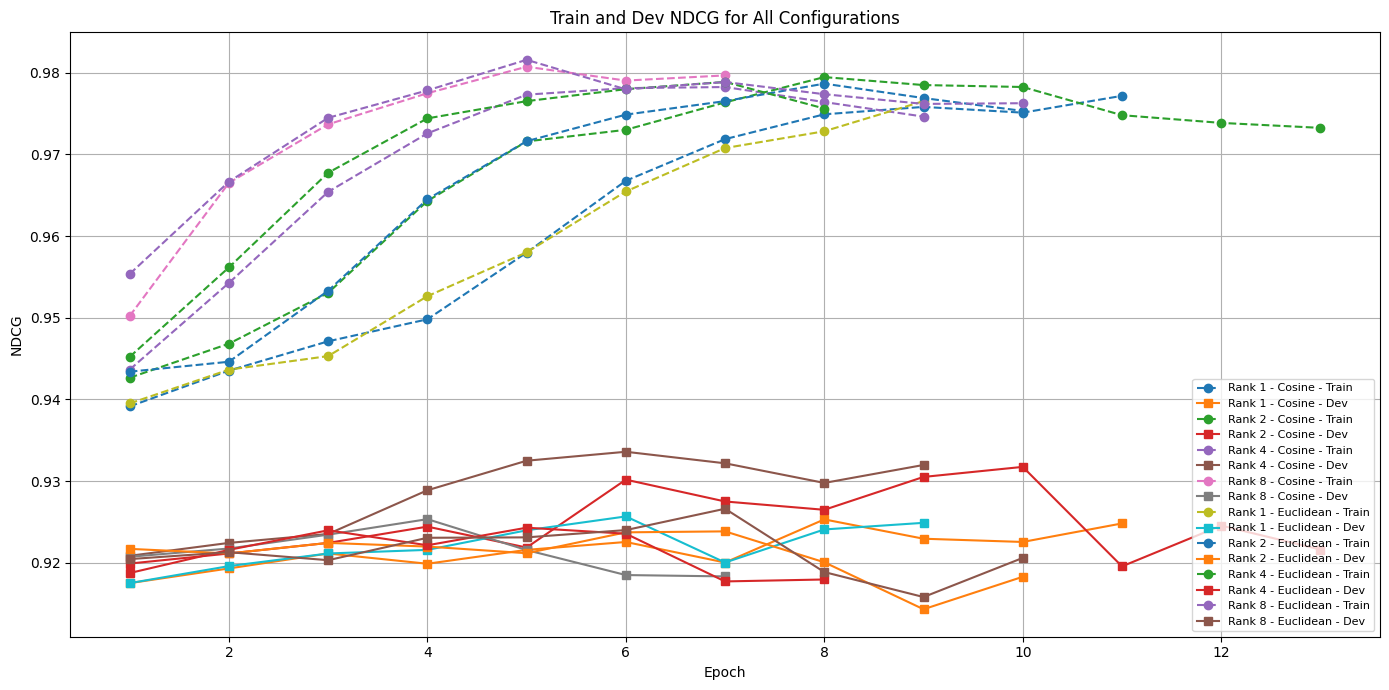

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

# List of (filepath, label)
csv_configs = [
    ("rank1_cosine_log.csv", "Rank 1 - Cosine"),
    ("rank2_cosine_log.csv", "Rank 2 - Cosine"),
    ("rank4_cosine_log.csv", "Rank 4 - Cosine"),
    ("rank8_cosine_log.csv", "Rank 8 - Cosine"),
    ("rank1_euclidean_log.csv", "Rank 1 - Euclidean"),
    ("rank2_euclidean_log.csv", "Rank 2 - Euclidean"),
    ("rank4_euclidean_log.csv", "Rank 4 - Euclidean"),
    ("rank8_euclidean_log.csv", "Rank 8 - Euclidean"),
]

plt.figure(figsize=(14, 7))

for filepath, label in csv_configs:
    df = pd.read_csv(filepath)
    plt.plot(df["epoch"], df["train_ndcg"], linestyle='--', marker='o', label=f"{label} - Train")
    plt.plot(df["epoch"], df["dev_ndcg"], linestyle='-', marker='s', label=f"{label} - Dev")

plt.title("Train and Dev NDCG for All Configurations")
plt.xlabel("Epoch")
plt.ylabel("NDCG")
plt.legend(loc="lower right", fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

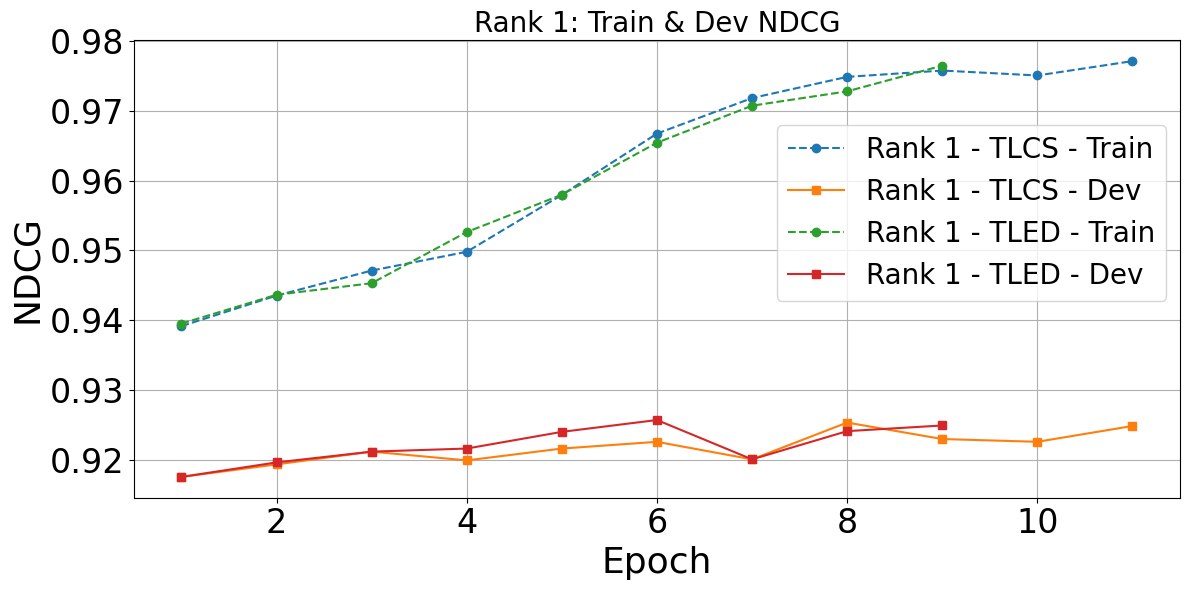

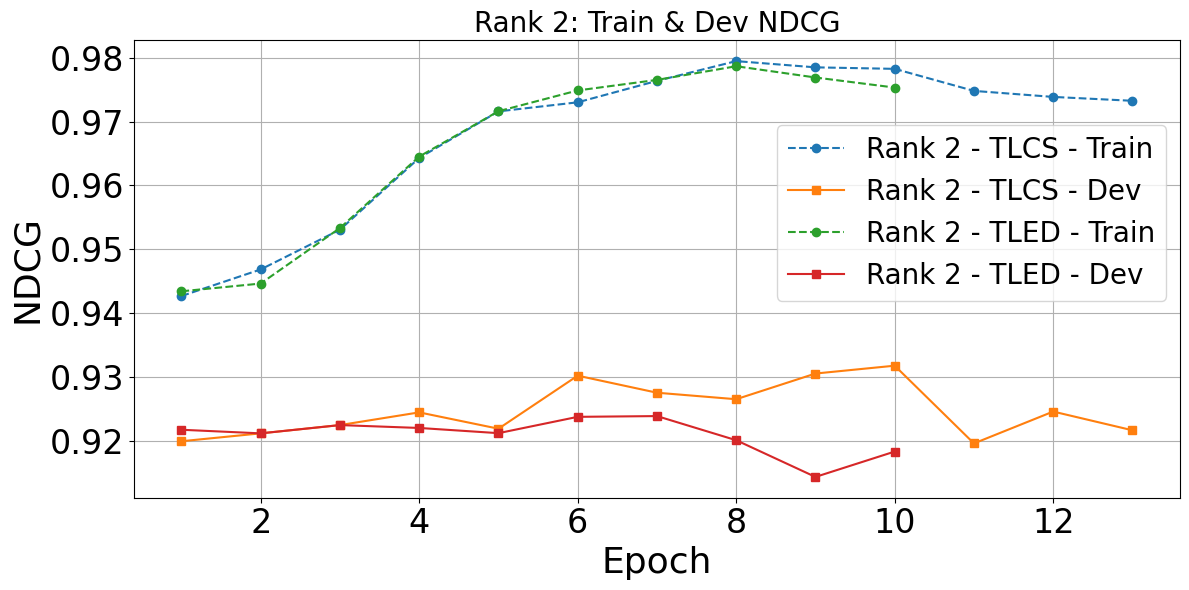

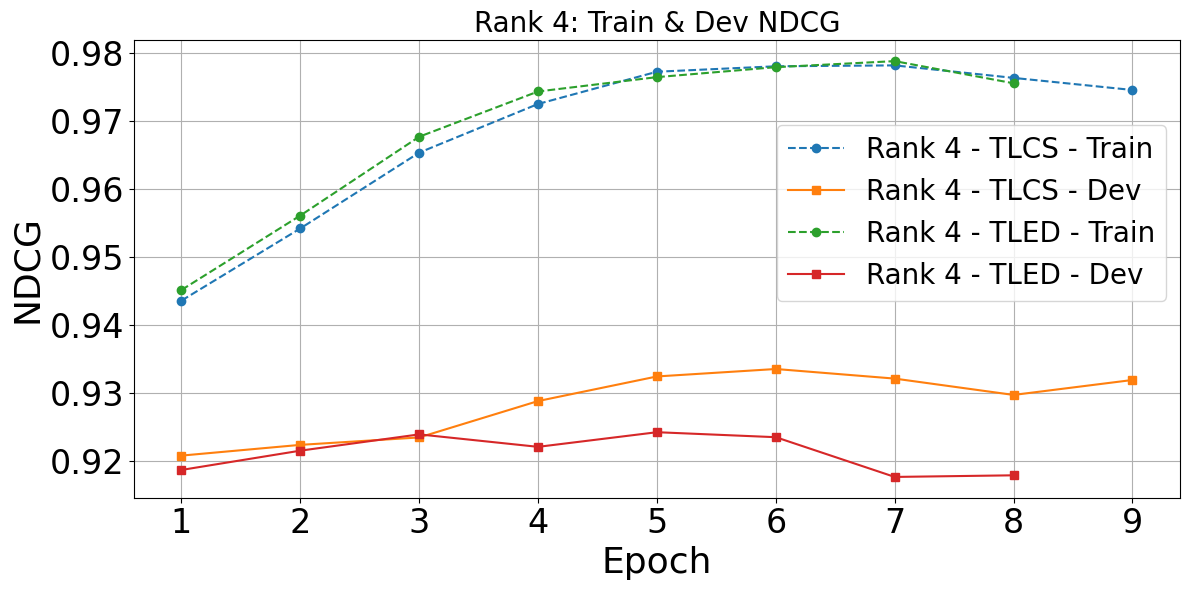

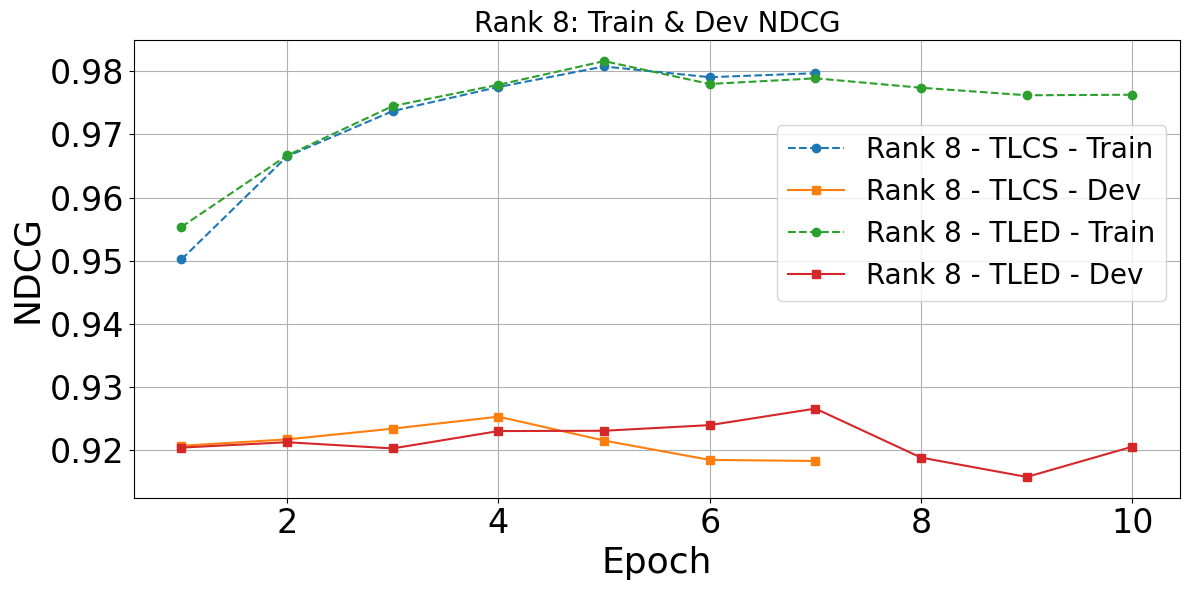

✅ Legend repositioned, enlarged plots shown and saved.


In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Input: list of (file path, label)
csv_configs = [
    ("rank1_cosine_log.csv", "Rank 1 - TLCS"),
    ("rank2_cosine_log.csv", "Rank 2 - TLCS"),
    ("rank4_cosine_log.csv", "Rank 4 - TLCS"),
    ("rank8_cosine_log.csv", "Rank 8 - TLCS"),
    ("rank1_euclidean_log.csv", "Rank 1 - TLED"),
    ("rank2_euclidean_log.csv", "Rank 2 - TLED"),
    ("rank4_euclidean_log.csv", "Rank 4 - TLED"),
    ("rank8_euclidean_log.csv", "Rank 8 - TLED"),
]

# Organize by rank
rank_configs = {1: [], 2: [], 4: [], 8: []}

for path, label in csv_configs:
    if "rank1" in path:
        rank_configs[1].append((path, label))
    elif "rank2" in path:
        rank_configs[2].append((path, label))
    elif "rank4" in path:
        rank_configs[4].append((path, label))
    elif "rank8" in path:
        rank_configs[8].append((path, label))

# Plot per rank and show + save
for rank in sorted(rank_configs.keys()):
    plt.figure(figsize=(12, 6))
    
    for filepath, label in rank_configs[rank]:
        df = pd.read_csv(filepath)
        plt.plot(df["epoch"], df["train_ndcg"], linestyle='--', marker='o', label=f"{label} - Train")
        plt.plot(df["epoch"], df["dev_ndcg"], linestyle='-', marker='s', label=f"{label} - Dev")
    
    plt.title(f"Rank {rank}: Train & Dev NDCG", fontsize=20)
    plt.xlabel("Epoch", fontsize=26)
    plt.ylabel("NDCG", fontsize=26)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    
    # Move legend a bit up (0.1 higher than default lower right)
    plt.legend(loc="lower right", bbox_to_anchor=(1, 0.40), fontsize=20)
    
    plt.grid(True)
    plt.tight_layout()
    
    filename = f"rank{rank}_ndcg_plot.png"
    plt.savefig(filename)
    plt.show()
    plt.close()

print("✅ Legend repositioned, enlarged plots shown and saved.")

✅ Combined avg_loss plot shown and saved as 'avg_loss_all_ranks_2x2.png'


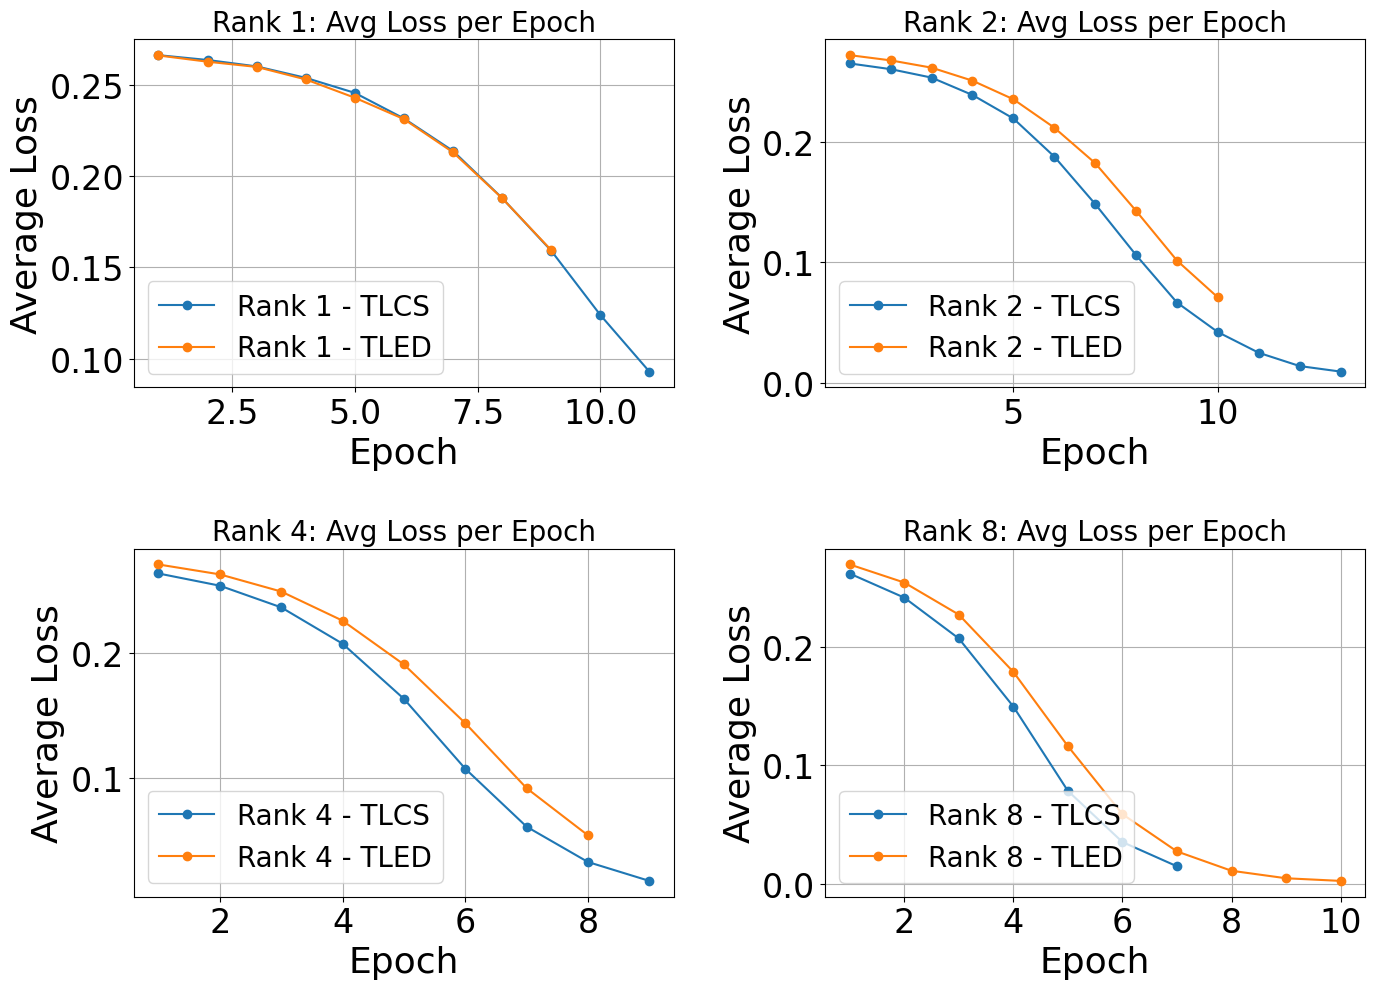

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Input: list of (file path, label)
csv_configs = [
    ("rank1_cosine_log.csv", "Rank 1 - TLCS"),
    ("rank2_cosine_log.csv", "Rank 2 - TLCS"),
    ("rank4_cosine_log.csv", "Rank 4 - TLCS"),
    ("rank8_cosine_log.csv", "Rank 8 - TLCS"),
    ("rank1_euclidean_log.csv", "Rank 1 - TLED"),
    ("rank2_euclidean_log.csv", "Rank 2 - TLED"),
    ("rank4_euclidean_log.csv", "Rank 4 - TLED"),
    ("rank8_euclidean_log.csv", "Rank 8 - TLED"),
]

# Organize by rank
rank_configs = {1: [], 2: [], 4: [], 8: []}

for path, label in csv_configs:
    if "rank1" in path:
        rank_configs[1].append((path, label))
    elif "rank2" in path:
        rank_configs[2].append((path, label))
    elif "rank4" in path:
        rank_configs[4].append((path, label))
    elif "rank8" in path:
        rank_configs[8].append((path, label))

# Create 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
rank_order = [1, 2, 4, 8]

for ax, rank in zip(axes.flat, rank_order):
    for filepath, label in rank_configs[rank]:
        df = pd.read_csv(filepath)
        ax.plot(df["epoch"], df["avg_loss"], marker='o', label=label)
    
    ax.set_title(f"Rank {rank}: Avg Loss per Epoch", fontsize=20)
    ax.set_xlabel("Epoch", fontsize=26)
    ax.set_ylabel("Average Loss", fontsize=26)
    ax.tick_params(axis='both', labelsize=24)
    ax.grid(True)
    ax.legend(fontsize=20, loc="lower left")

plt.tight_layout(h_pad=3.5, w_pad=3.5)

plt.savefig("avg_loss_all_ranks_2x2.png")


print("✅ Combined avg_loss plot shown and saved as 'avg_loss_all_ranks_2x2.png'")

In [66]:
import pandas as pd
import torch
from transformers import CLIPModel
from peft import get_peft_model, LoraConfig

# Define model configs and accuracy results
model_configs = [
    ("rank1_cosine_best.pt", "Rank 1 - Cosine", 1, True),
    ("rank2_cosine_best.pt", "Rank 2 - Cosine", 2, True),
    ("rank4_cosine_best.pt", "Rank 4 - Cosine", 4, True),
    ("rank8_cosine_best.pt", "Rank 8 - Cosine", 8, True),
    ("rank1_euclidean_best.pt", "Rank 1 - Euclidean", 1, False),
    ("rank2_euclidean_best.pt", "Rank 2 - Euclidean", 2, False),
    ("rank4_euclidean_best.pt", "Rank 4 - Euclidean", 4, False),
    ("rank8_euclidean_best.pt", "Rank 8 - Euclidean", 8, False),
]

results = []

for model_path, label, rank, use_cosine in model_configs:
    # Load model and apply LoRA
    base_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    lora_config = LoraConfig(
        r=rank,
        lora_alpha=2 * rank,
        target_modules=["q_proj", "v_proj"]
    )
    model = get_peft_model(base_model, lora_config)
    model.load_state_dict(torch.load(model_path, map_location="cpu"))
    model.eval()

    # Calculate accuracy
    dev_acc = calculate_1pc_accuracy(dev_df, "dev", model, use_cosine=use_cosine, gloss_cache=gloss_cache_dev)
    test_acc = calculate_1pc_accuracy(test_df, "test", model, use_cosine=use_cosine, gloss_cache=gloss_cache_test)

    results.append({
        "Model": label,
        "Dev 1pc Accuracy (%)": round(dev_acc * 100, 2),
        "Test 1pc Accuracy (%)": round(test_acc * 100, 2)
    })

# Save as CSV
accuracy_df = pd.DataFrame(results)
accuracy_df.to_csv("1pc_accuracy_table.csv", index=False)

print("✅ Accuracy table saved to '1pc_accuracy_table.csv'")

✅ Accuracy table saved to '1pc_accuracy_table.csv'
